<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

Juan Pablo Nieto Uribe

juanpablonietou@gmail.com

### Datos
El objecto es utilizar datos disponibles de convai de conversaciones en ingleś. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import re
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, Dense
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
import logging
from pathlib import Path
import pickle
from keras.layers import Input
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
#from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import os
import gdown
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 154MB/s]


In [ ]:
# dataset_file
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

In [ ]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
max_vocab_size=2000

In [ ]:
#Comenzamos con la implementación de word2idx y max_input_len
input_tokenizer=Tokenizer(num_words=max_vocab_size)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq=input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs=input_tokenizer.word_index

max_input_len=max(len(sen)for sen in input_integer_seq)

In [ ]:
print("Svarder",len(word2idx_inputs))
print("Mest longe", max_input_len)

Svarder 1799
Mest longe 9


In [ ]:
output_sentences

['hi how are you  <eos>',
 'not bad and you  <eos>',
 'hello  <eos>',
 'hello  <eos>',
 'hello how are you today  <eos>',
 'bro  <eos>',
 'where are you from  <eos>',
 'i am from russia and you  <eos>',
 'i am from the united states  <eos>',
 'you are racist  <eos>',
 'what is your favorite  <eos>',
 'i like reading do you  <eos>',
 'mee too  <eos>',
 'i like it a lot  <eos>',
 'cool i need to go see ya  <eos>',
 'see you  <eos>',
 'hello how are you  <eos>',
 'oh i have never been there  <eos>',
 'oh nice i love topic  <eos>',
 'hello how are you doing  <eos>',
 'great and how are you  <eos>',
 'taco bell i love them  <eos>',
 'hi <eos>',
 'who are you  <eos>',
 'i am dave what do you do  <eos>',
 'i m from cali what about you  <eos>',
 'c mon is there anybody here  <eos>',
 'that s cool  <eos>',
 'hey there how are you  <eos>',
 'cool do you have any hobbies  <eos>',
 'oh what genre  <eos>',
 'horror <eos>',
 'oh i hate horror movies  <eos>',
 'comedy <eos>',
 'ok see you soon  <eos>

In [ ]:
output_tokenizer=Tokenizer(num_words=max_vocab_size,filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n') #Usamos los parámetros que vienen por defecto
output_tokenizer.fit_on_texts(["<sos>","<eos>"]+output_sentences)
output_integer_seq=output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq=output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs=output_tokenizer.word_index

num_words_output=min(len(word2idx_outputs)+1,max_vocab_size)
max_out_len=max(len(sen) for sen in output_integer_seq)

In [ ]:
#Veamos la dimensión de las palabras del vocabulario y la sentencia más larga después de este proceso
print('Palabras en el vocab',len(word2idx_outputs))
print('Sentencia de salida más larglarga',max_out_len)

Palabras en el vocab 1806
Sentencia de salida más larglarga 10


In [ ]:
#Para evitar que explote la ram
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = int(max_input_len)
max_out_len = int(max_out_len)

In [ ]:
#Veamos la cantidad de rows del dataset
print('cantidad de rows del dataset',len(input_integer_seq))

cantidad de rows del dataset 6033


In [ ]:
encoder_input_sequences=pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences=pad_sequences(output_input_integer_seq,maxlen=max_out_len, padding='post')

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

In [ ]:
print('encoder_input_sequences shape',encoder_input_sequences.shape)
print('dec_input_seq shape',decoder_input_sequences.shape)

encoder_input_sequences shape (6033, 9)
dec_input_seq shape (6033, 10)


In [ ]:
decoder_targets.shape

(6033, 10, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:05<00:00, 103MB/s]


In [ ]:
class WordsEmbeddings(object):
  logger=logging.getLogger(__name__)

  def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

  def get_words_embeddings(self, words):
      words_idxs = self.words2idxs(words)
      return self.embeddings[words_idxs]['embedding']

  


  def words2idxs(self, words):
      return np.array([self.word2idx.get(word, -1) for word in words])

  def idxs2words(self, idxs):
      return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

  def load_model_from_pickle(self):
      self.logger.debug(
          'loading words embeddings from pickle {}'.format(
              self.PKL_PATH
          )
      )
      max_bytes = 2**28 - 1
      bytes_in = bytearray(0)
      input_size = os.path.getsize(self.PKL_PATH)
      with open(self.PKL_PATH, 'rb') as f_in:
          for _ in range(0, input_size, max_bytes):
              bytes_in += f_in.read(max_bytes)
      embeddings = pickle.loads(bytes_in)
      self.logger.debug('words embeddings loaded')
      return embeddings

  def convert_model_to_pickle(self):
      self.logger.debug(
          'converting and loading words embeddings from text file {}'.format(
              self.WORD_TO_VEC_MODEL_TXT_PATH
          )
      )
      structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                    ('embedding', np.float32, (self.N_FEATURES,))]
      structure = np.dtype(structure)
      with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
          embeddings_gen = (
              (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
              if len(line.split()[1:]) == self.N_FEATURES
          )
          embeddings = np.fromiter(embeddings_gen, structure)
      null_embedding = np.array(
          [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
          dtype=structure
      )
      embeddings = np.concatenate([embeddings, null_embedding])
      max_bytes = 2**28 - 1
      bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
      with open(self.PKL_PATH, 'wb') as f_out:
          for idx in range(0, len(bytes_out), max_bytes):
              f_out.write(bytes_out[idx:idx+max_bytes])
      self.logger.debug('words embeddings loaded')
      return embeddings

  def __init__(self):
    words_embedding_pkl=Path(self.PKL_PATH)
    if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
    else:
        embeddings = self.load_model_from_pickle()
    self.embeddings = embeddings
    index = np.arange(self.embeddings.shape[0])
    self.word2idx = dict(zip(self.embeddings['word'], index))
    self.idx2word = dict(zip(index, self.embeddings['word']))


In [ ]:
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [ ]:
model_embeddings = GloveEmbeddings()

In [ ]:
print('Estoy cargando')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(max_vocab_size, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)


Estoy cargando


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilice como referencias los ejemplos vistos en clase.

In [ ]:
max_input_len

9

In [ ]:
#Definimos las propiedades para entrenar
numero_units=128

#Encoder
encoder_inputs=Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(input_dim=nb_words, output_dim=embed_dim, input_length=max_input_len,weights=[embedding_matrix],trainable=False)

encoder_inputs_x=encoder_embedding_layer(encoder_inputs)

encoder=LSTM(numero_units,return_state=True)
encoder_outputs,estado_h,estado_c=encoder(encoder_inputs_x)
encoder_states=[estado_h,estado_c]

#Decoder
decoder_inputs=Input(shape=(max_out_len))
decoding_embedding_layer=Embedding(input_dim=num_words_output,output_dim=numero_units, input_length=max_out_len)
decoder_inputs_x=decoding_embedding_layer(decoder_inputs)
decoder_lstm=LSTM(numero_units,return_sequences=True,return_state=True)
decoder_outputs,_,_=decoder_lstm(decoder_inputs_x,initial_state=encoder_states)

#Nos vamos con la capa densa
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)
modelo=Model([encoder_inputs,decoder_inputs],decoder_outputs)

modelo.compile(loss='categorical_crossentropy',optimizer="Adam",metrics=['accuracy'])
modelo.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9, 50)        89950       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 128)      231296      ['input_2[0][0]']                
                                                                                              

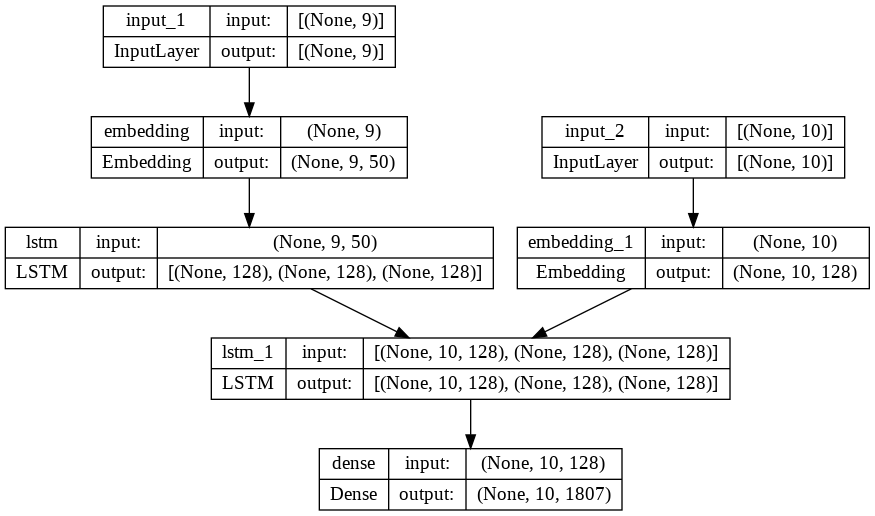

In [ ]:
#Hacemos el modelo completo compuesto por encoder y decoder.
plot_model(modelo, to_file='ploteamos_el_modelo.png',show_shapes=True,show_layer_names=True)

In [ ]:
#Definimos el encoder
encoder_model=Model(encoder_inputs,encoder_states)

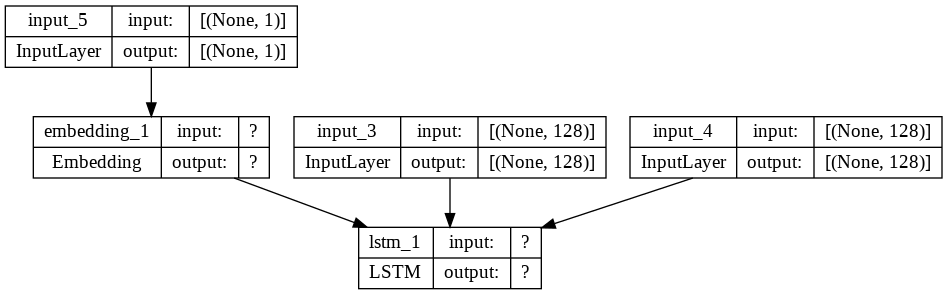

In [ ]:
#El modelo decoder es sobre el que vamos a hacer la inferencia
decoder_state_input_h=Input(shape=(numero_units,))
decoder_state_input_c=Input(shape=(numero_units,))
decoder_states_inputs=[decoder_state_input_h,decoder_state_input_c]

decoder_inputs_unico=Input(shape=(1,))
decoder_inputs_unico_x=decoding_embedding_layer(decoder_inputs_unico)

decoder_outputs,estado_h,estado_c=decoder_lstm(decoder_inputs_unico_x,initial_state=decoder_states_inputs)
estados_decoder=[estado_h,estado_c]
outputs_decoder=decoder_dense(decoder_outputs)
modelo_decoder=Model([decoder_inputs_unico]+decoder_states_inputs,[decoder_outputs] + estados_decoder)

plot_model(modelo_decoder, to_file='vamos_a_plotear_el_decoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
decoder_targets

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [ ]:
decoder_targets.shape

(6033, 10, 1807)

In [ ]:
encoder_input_sequences.shape

(6033, 9)

In [ ]:
decoder_input_sequences.shape

(6033, 10)

In [ ]:
decoder_targets.shape

(6033, 10, 1807)

In [ ]:
#hist = modelo.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets,epochs=10, validation_split=0.2)
hist = modelo.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets,epochs=50, validation_split=0.2)
#hist=modelo.fit([encoder_input_sequences,decoder_input_sequences],decoder_targets)

Epoch 1/50
151/151 [==============================] - 11s 15ms/step - loss: 3.0457 - accuracy: 0.5322 - val_loss: 2.2601 - val_accuracy: 0.6293
Epoch 2/50
151/151 [==============================] - 1s 10ms/step - loss: 2.0617 - accuracy: 0.6248 - val_loss: 2.0815 - val_accuracy: 0.6556
Epoch 3/50
151/151 [==============================] - 1s 10ms/step - loss: 1.8210 - accuracy: 0.6780 - val_loss: 1.9290 - val_accuracy: 0.6867
Epoch 4/50
151/151 [==============================] - 1s 10ms/step - loss: 1.6497 - accuracy: 0.7108 - val_loss: 1.8446 - val_accuracy: 0.7007
Epoch 5/50
151/151 [==============================] - 1s 9ms/step - loss: 1.5417 - accuracy: 0.7232 - val_loss: 1.7886 - val_accuracy: 0.7064
Epoch 6/50
151/151 [==============================] - 2s 11ms/step - loss: 1.4641 - accuracy: 0.7333 - val_loss: 1.7523 - val_accuracy: 0.7115
Epoch 7/50
151/151 [==============================] - 2s 12ms/step - loss: 1.4034 - accuracy: 0.7391 - val_loss: 1.7218 - val_accuracy: 0.7157

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
#Armemos los conversores
idx2word_input={v:k for k,v in word2idx_inputs.items()}
idx2word_target={v:k for k,v in word2idx_outputs.items()}

In [ ]:
def responder(en_seq):
  states_val=encoder_model.predict(en_seq)

  target_seq=np.zeros((1,1))
  target_seq[0,0]=word2idx_outputs['<sos>']

  xbs=word2idx_outputs['<eos>']

  output_sentence=[]

  for _ in range(max_out_len):
    output_tokens,h,c=modelo_decoder.predict([target_seq]+states_val)
    idx=np.argmax(output_tokens[0,0,:])

    if xbs==idx:
      break

    word=''
    if idx>0:
      palabra=idx2word_target[idx]
      output_sentence.append(palabra)

    states_val=[h,c]

    target_seq[0,0]=idx

  return ' '.join(output_sentence)

In [ ]:
pregunta_recibida='Nice to meet you'

pregunta_seq=input_tokenizer.texts_to_sequences([pregunta_recibida])[0]
#input_seq=encoder_input_sequences(input_seq)
encoder_sequence_test=pad_sequences([pregunta_seq],maxlen=max_input_len)
respuesta_generada=responder(encoder_sequence_test)
print('----------')

print('Pregunta:', pregunta_recibida)
print('Respuesta:', respuesta_generada)

print('----------')

1/1 [==============================] - 0s 14ms/step
----------
Pregunta: Nice to meet you
Respuesta: movies the dog and books pets m kind up too
----------
